In [13]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import os
from american_utils import AmericanPutData, plot_solution
%matplotlib inline
from model_types_am import *

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
N_EPOCH = 5000
LEARNING_RATE = 1e-3
HIDDEN_LAYER = 3
HIDDEN_WIDTH = 32
N_sample = 2000
EXPERIMENT_NAME = "exp0"
PHYSICS_PENALTY = 10
MODEL_TYPE = AmericanPut_gated3
BVP1_PENALTY = 1
INEQUALITY_PENALTY = 0.5
ERR_SAMPLING = False

experiment_dir = f"./{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [16]:
import logging
from datetime import datetime
logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

## Parameters for eperiments

In [18]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"PHYSICS_PENALTY: {PHYSICS_PENALTY}")
logging.info(f"BVP1_PENALTY: {BVP1_PENALTY}")
logging.info(f"ERR_SAMPLING: {ERR_SAMPLING}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [19]:
K = 40
r = 0.05
sigma = 0.2
T = 1
S_range = [0, 160]
t_range = [0, T]

In [20]:
amer_put_data = AmericanPutData(t_range,S_range,K,r,sigma)

## Boundary and Initial value

* BVP1 $S = S_{min}$: V = K

* BVP2 ($S = S_{max}$): $V = 0$

* IVP (t=T): $max(K-S,0)$ *call this initial but corresponds to expiry*

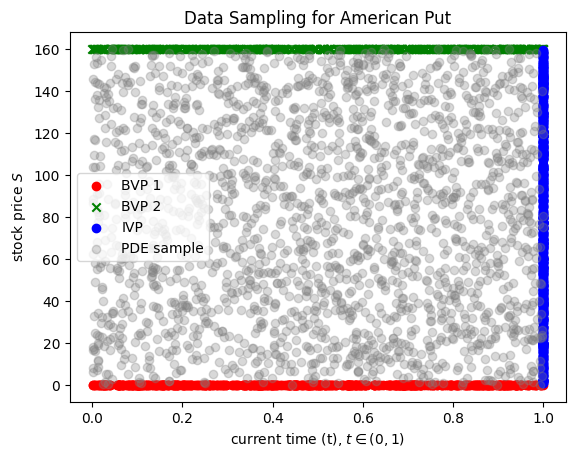

In [21]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = amer_put_data.get_bvp_data(500,1,1)
ivp_x1,ivp_y1 = amer_put_data.get_ivp_data(500,1)
diff_x1,diff_y1 = amer_put_data.get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel(f"current time (t), $t \in (0,1)$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for American Put")
plt.legend()

## Model Training and Inference

In [11]:
def get_sample_rt(l1,l2,l3):
    t = l1+l2+l3
    l1 = max(l1*3/t,0.25)
    l2 = max(l2*3/t,0.25)
    l3 = max(l3*3/t,0.25)
    return (l1,l2,l3)

In [12]:
model = MODEL_TYPE(2,1,HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
    "loss_inequality":[]
}

In [ ]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = amer_put_data.get_ivp_data_tensor(N_sample,r_ivp)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = amer_put_data.get_bvp_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = amer_put_data.get_diff_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    #pde region: wait till expiry
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS) - (r * y1_hat)
    #free region: option exercise immediately
    yint = torch.max(K - S1, torch.zeros_like(S1))
    free_pde = y1_hat-yint
    loss2 = PHYSICS_PENALTY * nn.MSELoss()(bs_pde*free_pde, torch.zeros_like(bs_pde*free_pde))
    #inequality loss
    loss3 = 0
    if bs_pde.item() >0:
       loss3+= nn.MSELoss()(bs_pde,torch.zeros_like(bs_pde))
    if free_pde.item()<0:
       loss3+=nn.MSELoss()(free_pde,torch.zeros_like(free_pde))
    loss3 = INEQUALITY_PENALTY*loss3

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss_history["loss_inequality"].append(loss3.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #normalise the ratios
    if ERR_SAMPLING:
      r_ivp,r_bvp1,r_bvp2 = get_sample_rt(mse_ivp.item(),mse_bvp1.item(),mse_bvp2.item())
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        logging.info(f"Epoch {i+1}, Loss: {loss.item():.4f}")
        if DEVICE.type !="cuda":
          print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    if (i+1) % 1000 == 0:
      plot_solution(model, amer_put_data, i+1, experiment_dir)